# 03. Model training for digit classification

In this part steps **"1. Retrieve image from camera / load image"** and **"2. Digit classification"** from the project pipeline will be covered. The retrieval from the camera is not covered here, see the previous notebook for the example code. 

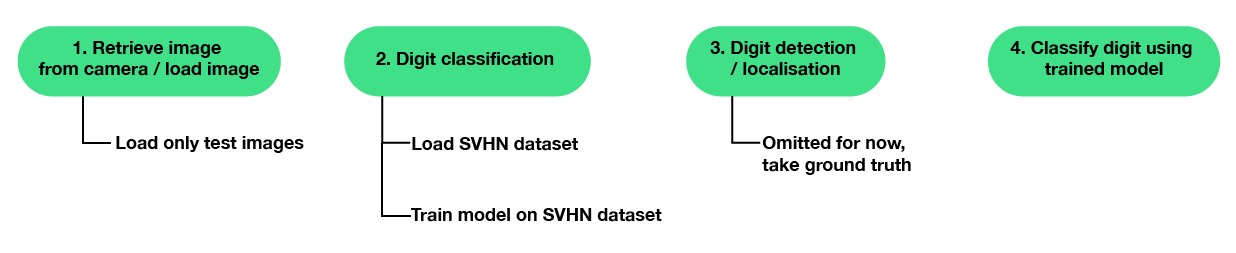

In [1]:
from IPython.display import Image
Image("./pipeline.png")

### Loading the test image

The image from the camera was exportes as a numpy array with grayscale values from the image. It is loaded with the following code:

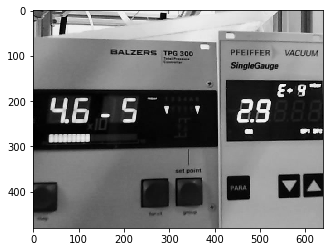

In [2]:
import matplotlib.pyplot as plt
from PressureReadoutObjectStorage import PressureReadoutObjectStorage

# create object, load test image
pro = PressureReadoutObjectStorage()
img = pro.read_test_image('./test_img.csv')

# plot the image
plt.imshow(img, cmap='gray')
plt.show()

### SVHN dataset

The SVHN dataset (http://ufldl.stanford.edu/housenumbers/) ...
> is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. 

It consists of 73257 training and 26032 test example images. These images are 32 by 32 pixels wide. To make things simple, we will use this framesize (32x32) throughout this project.

#### Load dataset

This function is included in the class SVHNDataset() but shown in the next cell. Be sure to change the path to the path to the dataset accordingly.

In [ ]:
import scipy.io as sio
import numpy as np
# function in class SVHNDataset()
def load_dataset(self, path_train, path_test):
    """
    Loads the .mat file from the SVHN Dataset (train and test) indicated at location path. Returns it as numpy array,
    """
    train_dataset = sio.loadmat(path_train)
    test_dataset = sio.loadmat(path_test)

    train_data, train_labels = train_dataset['X'], train_dataset['y']
    test_data, test_labels = test_dataset['X'], test_dataset['y']

    print( 'Train data:', train_data.shape,', Train labels:', train_labels.shape )
    print( 'Test data:', test_data.shape,', Test labels:', test_labels.shape )

    return train_data, train_labels, test_data, test_labels

In [12]:
from SVHNDataset import SVHNDataset
import numpy as np

svhn = SVHNDataset()

# change this to the path to the training and test dataset
path_train  = '/Users/hkromer/02_PhD/02_Data/12.dcr/Stanford_housenumbers/train_32x32.mat'
path_test  = '/Users/hkromer/02_PhD/02_Data/12.dcr/Stanford_housenumbers/test_32x32.mat'

train_data, train_labels, test_data, test_labels = svhn.load_dataset(path_train, path_test)

Train data: (32, 32, 3, 73257) , Train labels: (73257, 1)
Test data: (32, 32, 3, 26032) , Test labels: (26032, 1)


Let us plot 10 random examples from this dataset. The labels are atop the images.

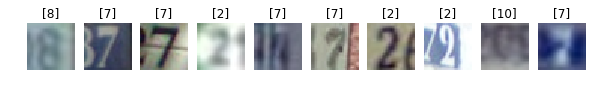

In [9]:
fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=10)
for ii in range(0, 10):
    jj = np.random.randint(0,train_data.shape[3])
    ax[ii].axis('off')
    ax[ii].set_title(train_labels[jj], loc='center')
    ax[ii].imshow(train_data[:,:,:,jj])

We see now, that the images are in RGB, so we will convert them to grayscale.

In [ ]:
# function in class SVHNDataset()
def convert_to_gray(self, data):
    """
    Converts all the images in the dataset into gray scale. Returns the dataset with grayscale entries.
    """

    r, g, b = data[:,:,0,:], data[:,:,1,:], data[:,:,2,:]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    data[:,:,0,:] = gray
    data = data[:,:,0,:]

    return data

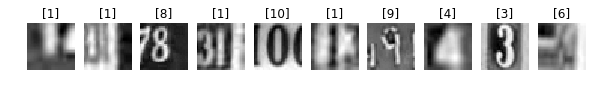

In [16]:
# convert to grayscale
train_data = svhn.convert_to_gray(train_data)
test_data = svhn.convert_to_gray(test_data)

# plot 10 random examples
fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=10)
for ii in range(0, 10):
    jj = np.random.randint(0,train_data.shape[2])
    ax[ii].axis('off')
    ax[ii].set_title(train_labels[jj], loc='center')
    ax[ii].imshow(train_data[:,:,jj], cmap='gray')

After converting to grayscale, we need to preprocess the datasets to be used with KERAS.

### Preprocessing datasets

To be used with KERAS, the feature dataset needs to have shape (number_of_examples, width, height, channels) and the labels dataset needs to be of shape (number_of_examples, ). Also, as we saw before, the dataset from SVHN is identifying the label "0" as "10". If we put the dataset as it is into KERAS, there will be an error, so we will take care of this by setting the 10's in the dataset to 0.

In [ ]:
import numpy as np
# function in class SVHNDataset()
def preprocess_for_KERAS_reshaping(self, framesize, dataset):
    """
    Preprocessing for the dataset to be used in KERAS.
    INPUT:
        - dataset: numpy array with shape (framesize, framesize, #examples). Should be
                    after the grayscaling step!
        - framesize: number that depicts the size of the frame, i.e. 32x32
    OUTPUT:
        - dataset that is still a numpy array. Shape is (#examples, framesize, framesize, 1)
    """
    dataset = np.rollaxis(dataset,2) # careful!

    dataset = dataset.reshape(-1, framesize, framesize, 1)

    return dataset

def preprocess_for_KERAS_labels(self, labels_dataset):
    """
    Preprocessing for the labels of dataset to be used in KERAS. Converts 10 to 0, and reshapes.
    INPUT:
        - labels_dataset: numpy array with shape (#examples,1).
    OUTPUT:
        - labels_dataset that is still a numpy array. Shape is (#examples,). 10 is replaced with 0
    """
    labels_dataset = labels_dataset[:,0]
    labels_dataset[labels_dataset==10] = 0

    return labels_dataset


In [17]:
print(f'Train data: {train_data.shape}, labels: {train_labels.shape}')
print(f'Test data: {test_data.shape}, labels: {test_labels.shape}')

Train data: (32, 32, 73257), labels: (73257, 1)
Test data: (32, 32, 26032), labels: (26032, 1)


In [19]:
X_train = svhn.preprocess_for_KERAS_reshaping(framesize=32, dataset=train_data)
X_test = svhn.preprocess_for_KERAS_reshaping(framesize=32, dataset=test_data)
print(f'X_train data: {X_train.shape}')
print(f'X_test data: {X_test.shape}')

X_train data: (73257, 32, 32, 1)
X_test data: (26032, 32, 32, 1)


In [20]:
y_train = svhn.preprocess_for_KERAS_labels(train_labels)
y_test = svhn.preprocess_for_KERAS_labels(test_labels)
print(f'Train labels: {y_train.shape}')
print(f'Test  labels: {y_test.shape}')

Train labels: (73257,)
Test  labels: (26032,)


#### Model definition and compiling

Neural networks have proven very capable in image classification challenges. The architecture of the model in this project is taken from https://nbviewer.jupyter.org/github/dyckia/SVHN-CNN/blob/master/SVHN.ipynb that has proven to have high accuracy and can train on the MacBookPro 2018 used here.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

# function in class SVHNDataset()
def model_definition(self):
    """
    Builds the model for the digit detection.
    Taken from https://nbviewer.jupyter.org/github/dyckia/SVHN-CNN/blob/master/SVHN.ipynb.
    """

    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(64, (3,3), activation='relu'),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])

    return model

In [21]:
model = svhn.model_definition()

# define the optimizer, loss function and metrics for the network
model.compile(optimizer='adam', # others could also be checked
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

#### Training and saving

Training this model takes around 1 hour. Important note: On my machine, if the line `os.environ['KMP_DUPLICATE_LIB_OK']='True'` is not included, there will be an error and the kernel will die when saving (or loading) a model.

In [ ]:
# start training
history = model.fit(X_train, y_train, epochs=10)

In [ ]:
import h5py
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

model.save('./2019-19-21.KERAS_model.h5')